In [2]:
from IPython.display import Image
import os
import shutil
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

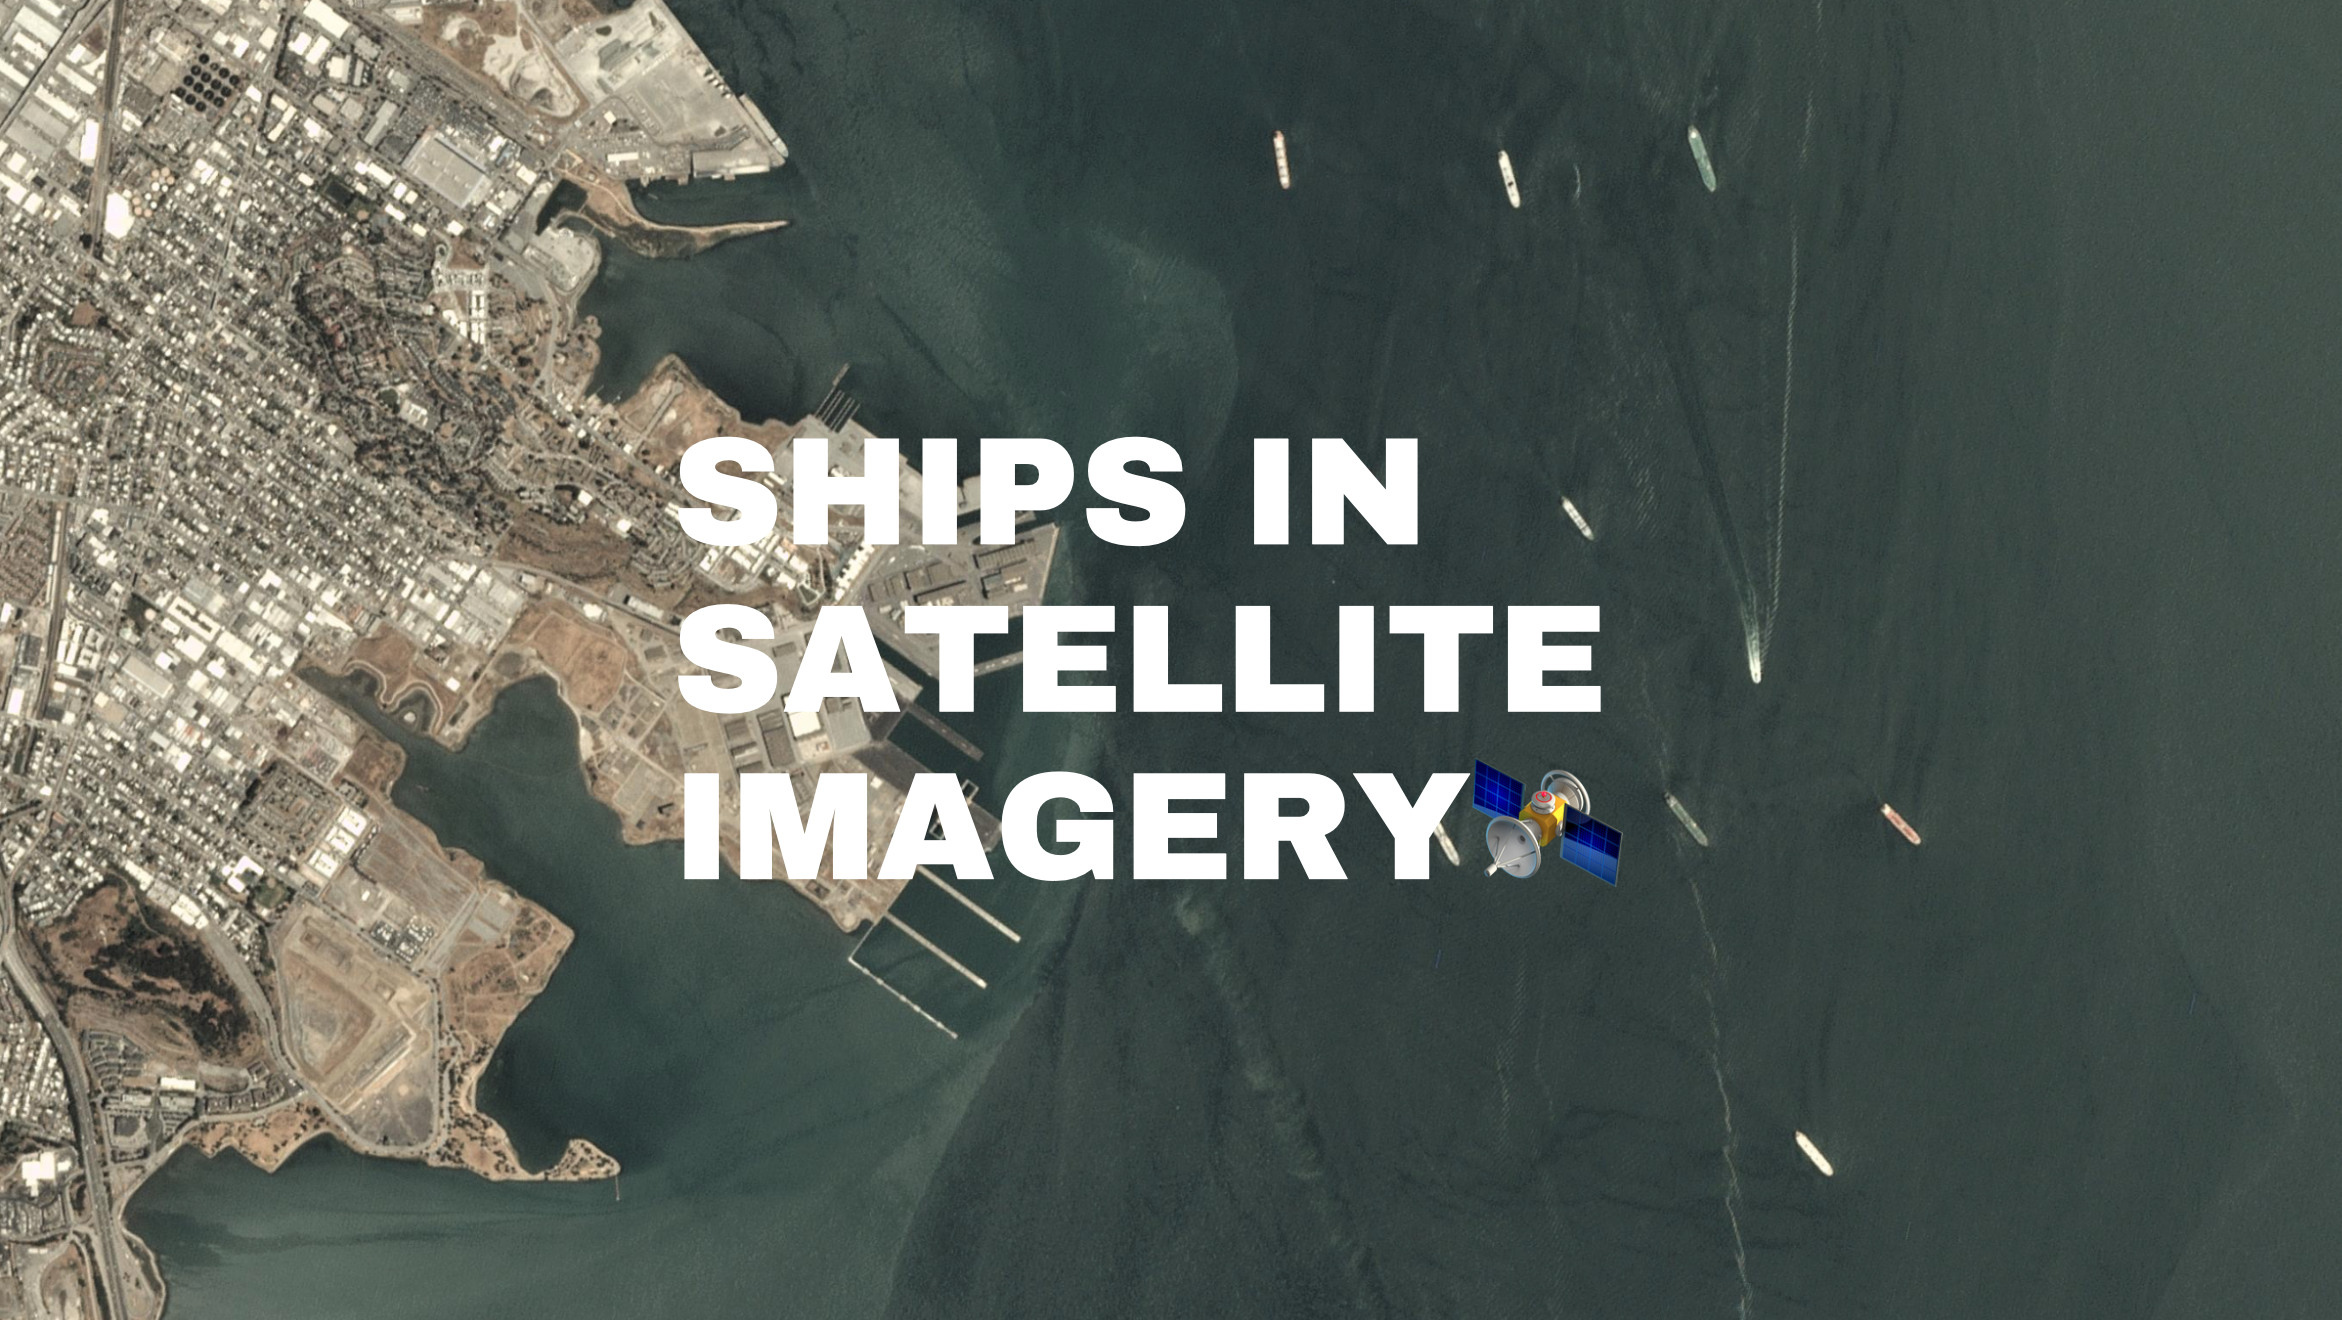

In [83]:
Image(filename='/content/banner1.png', height=720, width=1280)

#Problem Definition

> *From Kaggle*:

>Satellite imagery provides unique insights into various markets, including agriculture, defense and intelligence, energy, and finance. New commercial imagery providers, such as Planet, are using constellations of small satellites to capture images of the entire Earth every day.

>This flood of new imagery is outgrowing the ability for organizations to manually look at each image that gets captured, and there is a need for machine learning and computer vision algorithms to help automate the analysis process.

>The aim of this dataset is to help address the difficult task of detecting the location of large ships in satellite images. Automating this process can be applied to many issues including monitoring port activity levels and supply chain analysis.

#What kind of data do we have?

> This Dataset was sourced from [Kaggle]('https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery')

#Success Definition

> The ability of the model to successfully identify ships with >90% accuracy on unseen data.

In [12]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [14]:
!kaggle datasets download -d rhammell/ships-in-satellite-imagery

100% 185M/185M [00:09<00:00, 21.5MB/s]
100% 185M/185M [00:09<00:00, 19.9MB/s]


In [15]:
!unzip '/content/ships-in-satellite-imagery.zip'

Archive:  /content/ships-in-satellite-imagery.zip
  inflating: scenes/scenes/lb_1.png  
  inflating: scenes/scenes/lb_2.png  
  inflating: scenes/scenes/lb_3.png  
  inflating: scenes/scenes/lb_4.png  
  inflating: scenes/scenes/sfbay_1.png  
  inflating: scenes/scenes/sfbay_2.png  
  inflating: scenes/scenes/sfbay_3.png  
  inflating: scenes/scenes/sfbay_4.png  
  inflating: shipsnet.json           
  inflating: shipsnet/shipsnet/0__20150718_184300_090b__-122.35324421973536_37.772113980272394.png  
  inflating: shipsnet/shipsnet/0__20150718_184300_090b__-122.38458613431831_37.763521076612484.png  
  inflating: shipsnet/shipsnet/0__20150718_184300_090b__-122.40477488428849_37.8071040053892.png  
  inflating: shipsnet/shipsnet/0__20150718_184300_090b__-122.42663861582857_37.80913223576201.png  
  inflating: shipsnet/shipsnet/0__20150720_184302_0906__-122.21893759782994_37.87172273326103.png  
  inflating: shipsnet/shipsnet/0__20150830_000650_0b07__-122.37967271362145_37.76049394246638.p

In [16]:
data = pd.read_json('shipsnet.json')

In [17]:
data.head()

data  labels  \
0  [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...       1   
1  [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...       1   
2  [125, 127, 129, 130, 126, 125, 129, 133, 132, ...       1   
3  [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...       1   
4  [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...       1   

                                   locations             scene_ids  
0    [-118.2254694333423, 33.73803725920789]  20180708_180909_0f47  
1    [-122.33222866289329, 37.7491755586813]  20170705_180816_103e  
2  [-118.14283073363218, 33.736016066914175]  20180712_211331_0f06  
3   [-122.34784341495181, 37.76648707436548]  20170609_180756_103a  
4   [-122.34852408322172, 37.75878462398653]  20170515_180653_1007

In [18]:
#Creating Data Folder and Label Folders

os.makedirs('/content/TRAIN')
os.makedirs('/content/TRAIN/0')
os.makedirs('/content/TRAIN/1')

os.makedirs('/content/TEST')
os.makedirs('/content/TEST/0')
os.makedirs('/content/TEST/1')

In [19]:
images = os.listdir('/content/shipsnet/shipsnet')

In [20]:
#Shuffling the images and splitting them into Train and Test sets

random.shuffle(images)
train_images = images[:3000]
test_images = images[3000:]

In [21]:
len(test_images)

1000

In [22]:
#Moving the images into appropriate directories

for image in train_images:
  if image.startswith('0'):
    shutil.copy('/content/shipsnet/shipsnet/'+ image, '/content/TRAIN/0')
  else:
    shutil.copy('/content/shipsnet/shipsnet/'+ image, '/content/TRAIN/1')

for image in test_images:
  if image.startswith('0'):
    shutil.copy('/content/shipsnet/shipsnet/'+ image, '/content/TEST/0')
  else:
    shutil.copy('/content/shipsnet/shipsnet/'+ image, '/content/TEST/1')

In [23]:
#Creating ImageDataGenerators

train_dir = '/content/TRAIN'
test_dir = '/content/TEST'

#Our data generators will normalize the pixel values and add some data augmentation to the training set

train_datagen = ImageDataGenerator(rescale = 1/255., horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data = train_datagen.flow_from_directory(train_dir, batch_size=32, class_mode='binary', target_size=(80,80))
test_data = test_datagen.flow_from_directory(test_dir, batch_size=32, class_mode='binary', target_size=(80,80))
test_data_for_preds = test_datagen.flow_from_directory(test_dir, batch_size=1000, class_mode='binary', target_size=(80,80), shuffle=False)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#Modelling

In [24]:
model = Sequential([
    Conv2D(10,3,input_shape=(80,80,3), activation='relu'),
    Conv2D(10,3,activation='relu'),
    MaxPool2D(2,1),
    Conv2D(10,3,activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile( loss = 'binary_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

In [28]:
#Fitting the model 

history = model.fit(train_data, epochs=100, validation_data = test_data, callbacks=[lr_scheduler])

Epoch 1/100
94/94 [==============================] - 4s 47ms/step - loss: 0.1762 - accuracy: 0.9293 - val_loss: 0.1589 - val_accuracy: 0.9320 - lr: 1.0000e-04
Epoch 2/100
94/94 [==============================] - 3s 34ms/step - loss: 0.1678 - accuracy: 0.9320 - val_loss: 0.1590 - val_accuracy: 0.9320 - lr: 1.1220e-04
Epoch 3/100
94/94 [==============================] - 3s 34ms/step - loss: 0.1655 - accuracy: 0.9360 - val_loss: 0.1434 - val_accuracy: 0.9420 - lr: 1.2589e-04
Epoch 4/100
94/94 [==============================] - 4s 39ms/step - loss: 0.1611 - accuracy: 0.9340 - val_loss: 0.1436 - val_accuracy: 0.9430 - lr: 1.4125e-04
Epoch 5/100
94/94 [==============================] - 4s 40ms/step - loss: 0.1651 - accuracy: 0.9313 - val_loss: 0.1378 - val_accuracy: 0.9470 - lr: 1.5849e-04
Epoch 6/100
94/94 [==============================] - 4s 41ms/step - loss: 0.1563 - accuracy: 0.9363 - val_loss: 0.1324 - val_accuracy: 0.9450 - lr: 1.7783e-04
Epoch 7/100
94/94 [===========================

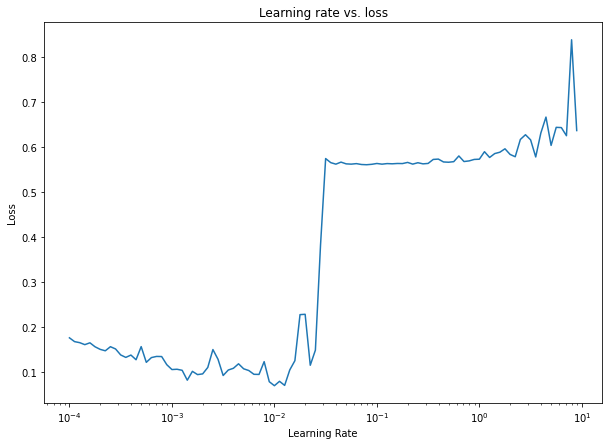

In [30]:
#Let's find the best learning rate for our model
%matplotlib inline

lr = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

In [ ]:
#Seems that the best learning rate was the default one

<AxesSubplot:>

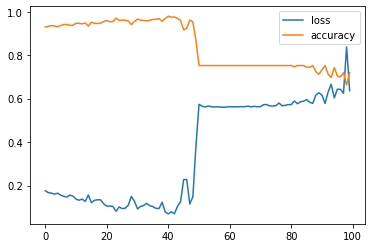

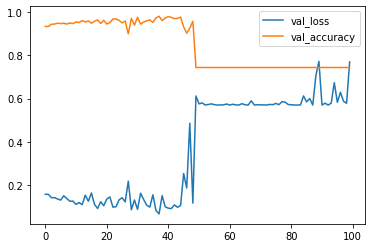

In [38]:
#Let's check if the model is overfitting
%matplotlib inline

pd.DataFrame(history.history).drop(['val_loss', 'val_accuracy', 'lr'], axis=1).plot()
pd.DataFrame(history.history).drop(['loss', 'accuracy', 'lr'], axis=1).plot()

In [39]:
model1 = Sequential([
    Conv2D(10,3,input_shape=(80,80,3), activation='relu'),
    Conv2D(10,3,activation='relu'),
    MaxPool2D(2,1),
    Conv2D(10,3,activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

model1.compile( loss = 'binary_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])

In [40]:
history1 = model1.fit(train_data, epochs=10, validation_data = test_data)

Epoch 1/10
94/94 [==============================] - 6s 48ms/step - loss: 0.3438 - accuracy: 0.8457 - val_loss: 0.1980 - val_accuracy: 0.9110
Epoch 2/10
94/94 [==============================] - 4s 40ms/step - loss: 0.1794 - accuracy: 0.9237 - val_loss: 0.1366 - val_accuracy: 0.9530
Epoch 3/10
94/94 [==============================] - 3s 34ms/step - loss: 0.1692 - accuracy: 0.9333 - val_loss: 0.1263 - val_accuracy: 0.9500
Epoch 4/10
94/94 [==============================] - 4s 40ms/step - loss: 0.1600 - accuracy: 0.9320 - val_loss: 0.1259 - val_accuracy: 0.9450
Epoch 5/10
94/94 [==============================] - 3s 33ms/step - loss: 0.1539 - accuracy: 0.9370 - val_loss: 0.1734 - val_accuracy: 0.9260
Epoch 6/10
94/94 [==============================] - 3s 34ms/step - loss: 0.1434 - accuracy: 0.9413 - val_loss: 0.1127 - val_accuracy: 0.9550
Epoch 7/10
94/94 [==============================] - 4s 40ms/step - loss: 0.1259 - accuracy: 0.9517 - val_loss: 0.1099 - val_accuracy: 0.9640
Epoch 8/10
94

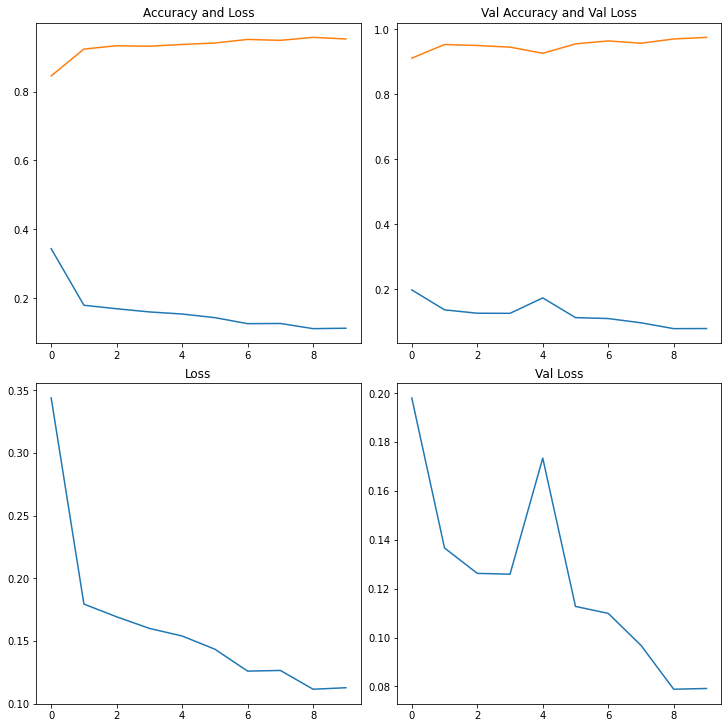

In [81]:
#Let's check if the model is overfitting
%matplotlib inline


fig, ax  = plt.subplots(nrows=2, ncols=2, figsize=(10,10), layout='constrained')

ax[0,0].plot(pd.DataFrame(history1.history).drop(['val_loss', 'val_accuracy'], axis=1))
ax[0,0].set(title='Accuracy and Loss')
ax[0,1].plot(pd.DataFrame(history1.history).drop(['loss', 'accuracy'], axis=1))
ax[0,1].set(title='Val Accuracy and Val Loss')
ax[1,0].plot(pd.DataFrame(history1.history).drop(['val_loss', 'val_accuracy', 'accuracy'], axis=1))
ax[1,0].set(title='Loss')
ax[1,1].plot(pd.DataFrame(history1.history).drop(['loss', 'accuracy', 'val_accuracy'], axis=1))
ax[1,1].set(title='Val Loss');

> It is evident that the model which uses the default learning rate performs very well.

#Evaluating the model

In [84]:
#Creating evaluation functions

def evaluate_model(true_labels, preds):
    
    evaluation = {
        "Accuracy Score: ": str(round(accuracy_score(true_labels, preds)*100, 2))+'%',
        "Recall Score": str(round(recall_score(true_labels, preds)*100, 2))+'%',
        "F1 Score": str(round(f1_score(true_labels, preds)*100, 2))+'%',
        "Precision Score: ": str(round(precision_score(true_labels, preds)*100, 2))+'%'
    }
    
    return evaluation

def conf_matrix(true_labels, preds):
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(confusion_matrix(true_labels, preds), annot=True, cbar=True, fmt='g')

from sklearn.metrics import RocCurveDisplay

In [53]:
X, y_true = test_data_for_preds.next()
y_pred = model1.predict(test_data_for_preds)
y_pred = np.round(y_pred)

1/1 [==============================] - 1s 721ms/step


In [56]:
evaluate_model(y_true, y_pred)

{'Accuracy Score: ': '97.5%',
 'Recall Score': '96.89%',
 'F1 Score': '95.22%',
 'Precision Score: ': '93.61%'}

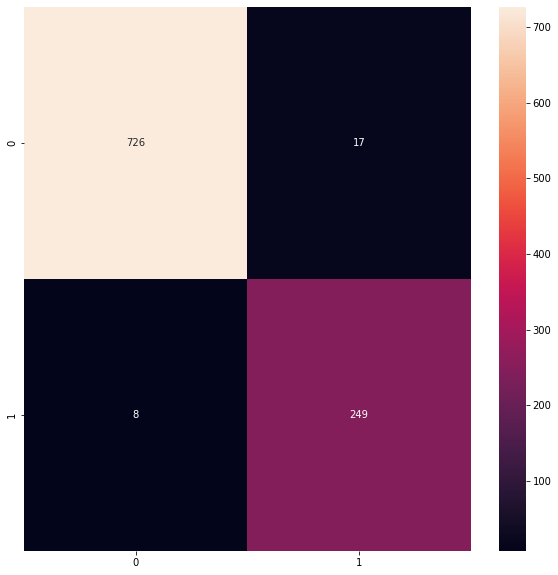

In [85]:
conf_matrix(y_true, y_pred)

>**Conclusion** 

>This simple CNN model can differentiate between pictures which are not ships and those which are ships, quite accurately. With that being said, I would like to implement Object Recognition into this project in the future.